In [1]:
%matplotlib inline



The [mne.Epochs](https://martinos.org/mne/dev/generated/mne.Epochs.html) data structure: epoched data
=============================================================

[Epochs](https://martinos.org/mne/dev/generated/mne.Epochs.html) objects are a way of representing continuous
data as a collection of time-locked trials, stored in an array of shape
``(n_events, n_channels, n_times)``. They are useful for many statistical
methods in neuroscience, and make it easy to quickly overview what occurs
during a trial.



Creating epochs
=============

[Epochs](https://martinos.org/mne/dev/generated/mne.Epochs.html) objects can be created in three ways:
 1. From a [Raw](https://martinos.org/mne/stable/generated/mne.io.Raw.html) object, along with event times
 2. From an [Epochs](https://martinos.org/mne/dev/generated/mne.Epochs.html) object that has been saved as a
    `.fif` file
 3. From scratch using [EpochsArray](https://martinos.org/mne/dev/generated/mne.EpochsArray.html#mne.EpochsArray). See
    [Creating MNE's data structures from scratch](https://martinos.org/mne/stable/auto_tutorials/plot_creating_data_structures.html#tut-creating-data-structures)



Import packages

In [2]:
import mne
import os.path as op
import numpy as np
from matplotlib import pyplot as plt

Then, we will load the data

In [3]:
data_path = mne.datasets.sample.data_path()
# Load a dataset that contains events
raw = mne.io.read_raw_fif(
    op.join(data_path, 'MEG', 'sample', 'sample_audvis_raw.fif'))

Opening raw data file /home/mainak/Desktop/projects/github_repos/mne-python/examples/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0


Extract events
--------------

In [4]:
# If your raw object has a stim channel, you can construct an event array
# easily
events = mne.find_events(raw, stim_channel='STI 014')

320 events found
Event IDs: [ 1  2  3  4  5 32]


Look at the first 5 events (onset, value before event, event id):

In [5]:
print(events[:5])

[[27977     0     2]
 [28345     0     3]
 [28771     0     1]
 [29219     0     4]
 [29652     0     2]]


We can plot the events

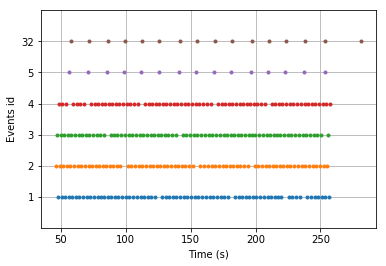

In [6]:
mne.viz.plot_events(events, sfreq=raw.info['sfreq']);

Specify event codes of interest with descriptive labels.

In [7]:
# This dataset also has visual left (3) and right (4) events, but
# to save time and memory we'll just look at the auditory conditions
# for now.
event_id = {'Auditory/Left': 1, 'Auditory/Right': 2}

Expose the raw data as epochs, cut from -0.1 s to 1.0 s relative to the event
onsets



In [8]:
epochs = mne.Epochs(raw, events, event_id, tmin=-0.1, tmax=1,
                    baseline=(None, 0), preload=True)
print(epochs)

145 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Loading data for 145 events and 662 original time points ...
0 bad epochs dropped
<Epochs  |   145 events (all good), -0.0998976 - 1.00064 sec, baseline [None, 0], ~279.0 MB, data loaded,
 'Auditory/Left': 72
 'Auditory/Right': 73>


Note that epochs constructed in this manner will not have their
data available until explicitly read into memory, which you can do with
[get_data](https://martinos.org/mne/dev/generated/mne.Epochs.html#mne.Epochs.get_data). Alternatively, you can use
`preload=True`.

Epochs behave similarly to [`mne.io.Raw`](https://martinos.org/mne/dev/generated/mne.io.Raw.html#mne.io.Raw) objects. They have an
[`info`](https://martinos.org/mne/dev/generated/mne.Info.html#mne.Info) attribute that has all of the same
information, as well as a number of attributes unique to the events contained
within the object.



In [9]:
print(epochs.events[:3])
print(epochs.event_id)

[[27977     0     2]
 [28771     0     1]
 [29652     0     2]]
{'Auditory/Left': 1, 'Auditory/Right': 2}


Indexing epochs
=============

You can select subsets of epochs by indexing the [Epochs](https://martinos.org/mne/dev/generated/mne.Epochs.html) 
object directly. Alternatively, if you have epoch names specified in
`event_id` then you may index with strings instead.


In [10]:
print(epochs[1:5])
print(epochs['Auditory/Right'])

<Epochs  |   4 events (all good), -0.0998976 - 1.00064 sec, baseline [None, 0], ~11.2 MB, data loaded,
 'Auditory/Left': 2
 'Auditory/Right': 2>
<Epochs  |   73 events (all good), -0.0998976 - 1.00064 sec, baseline [None, 0], ~142.3 MB, data loaded,
 'Auditory/Right': 73>


Note the '/'s in the event code labels. These separators allow tag-based
selection of epoch sets; 

Every string separated by '/' can be entered, and
returns the subset of epochs matching any of the strings. E.g.,



In [11]:
print(epochs['Right'])
print(epochs['Right', 'Left'])

<Epochs  |   73 events (all good), -0.0998976 - 1.00064 sec, baseline [None, 0], ~142.3 MB, data loaded,
 'Auditory/Right': 73>
<Epochs  |   145 events (all good), -0.0998976 - 1.00064 sec, baseline [None, 0], ~279.0 MB, data loaded,
 'Auditory/Left': 72
 'Auditory/Right': 73>


In [12]:
print(epochs['Auditory'])

<Epochs  |   145 events (all good), -0.0998976 - 1.00064 sec, baseline [None, 0], ~279.0 MB, data loaded,
 'Auditory/Left': 72
 'Auditory/Right': 73>


Note that MNE will not complain if you ask for tags not present in the
object, as long as it can find some match: the below example is parsed as
(inclusive) 'Right' OR 'Left'. However, if no match is found, an error is
returned.



In [13]:
epochs_r = epochs['Right']
epochs_still_only_r = epochs_r[['Right', 'Left']]
print(epochs_still_only_r)

try:
    epochs_still_only_r["Left"]
except KeyError: 
    print("Tag-based selection without any matches raises a KeyError!")

<Epochs  |   73 events (all good), -0.0998976 - 1.00064 sec, baseline [None, 0], ~142.3 MB, data loaded,
 'Auditory/Right': 73>
Tag-based selection without any matches raises a KeyError!


It is also possible to iterate through [`Epochs`](https://martinos.org/mne/stable/generated/mne.Epochs.html#mne.Epochs) objects
in this way. Note that behavior is different if you iterate on `Epochs`
directly rather than indexing:



In [14]:
# These will be epochs objects
for i in range(3):
    print(epochs[i])

# These will be arrays
for ep in epochs[:2]:
    print(ep)

<Epochs  |   1 events (all good), -0.0998976 - 1.00064 sec, baseline [None, 0], ~5.5 MB, data loaded,
 'Auditory/Right': 1>
<Epochs  |   1 events (all good), -0.0998976 - 1.00064 sec, baseline [None, 0], ~5.5 MB, data loaded,
 'Auditory/Left': 1>
<Epochs  |   1 events (all good), -0.0998976 - 1.00064 sec, baseline [None, 0], ~5.5 MB, data loaded,
 'Auditory/Right': 1>
[[-1.56510152e-12 -6.00746037e-13  3.63609444e-13 ... -5.42252344e-12
  -3.49381248e-12  8.07845329e-12]
 [ 4.71111366e-12  2.78240270e-12 -1.10663744e-13 ... -2.03937471e-12
  -1.07501922e-12  1.81804722e-12]
 [ 1.27694161e-13  1.26810933e-13  8.74659808e-14 ...  3.27176412e-14
   5.59107736e-14  6.80975243e-14]
 ...
 [-7.88218509e-06 -9.77900515e-06 -9.28950320e-06 ... -6.53605473e-06
  -7.14793216e-06 -8.80000125e-06]
 [-6.95813002e-06 -8.06909195e-06 -7.19201674e-06 ... -6.25646985e-06
  -6.60729993e-06 -8.36145036e-06]
 [ 1.26772322e-05  1.26772322e-05  1.33309187e-05 ... -1.41239155e-05
  -1.41239155e-05 -1.15091693

Dropping epochs
-------------------------

* Manually by using [epochs.drop(idx)](https://martinos.org/mne/stable/generated/mne.Epochs.html#mne.Epochs.drop), 
* Using rejection or flat thresholds with [epochs.drop_bad(reject, flat)](https://martinos.org/mne/stable/generated/mne.Epochs.html#mne.Epochs.drop_bad).

In [15]:
epochs.drop([0], reason='User reason')
epochs.drop_bad(reject=dict(grad=2500e-13, mag=4e-12, eog=200e-6), flat=None)

Dropped 1 epoch
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1421']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1421']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch

<Epochs  |   121 events (all good), -0.0998976 - 1.00064 sec, baseline [None, 0], ~233.4 MB, data loaded,
 'Auditory/Left': 57
 'Auditory/Right': 64>

You can also inspect the reason why epochs were dropped.

In [16]:
print(epochs.drop_log);

[['User reason'], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], ['EOG 061'], ['IGNORED'], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], ['IGNORED'], [], ['IGNORED'], ['EOG 061'], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], ['IGNORED'], ['EOG 061'], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], ['IGNORED'], ['IGNORED'], ['IGNORED'], ['EOG 061'], ['IGNORED'], ['EOG 061'], ['IGNORED'], ['EOG 061'], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], ['IGNORED'], [], ['IGNORED'], [], ['IGNORED'], [], ['IG

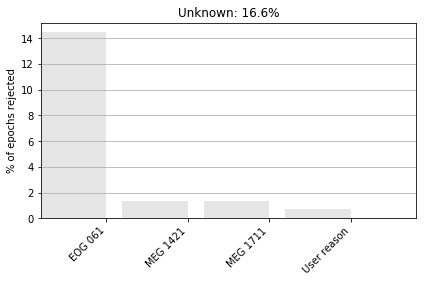

In [17]:
epochs.plot_drop_log();

The indices from the original set of events are stored in ``epochs.selection``.

In [18]:
print(epochs.selection)

[  2   4   6   8  10  12  14  19  21  23  25  27  29  31  33  35  38  42
  44  46  48  50  52  54  56  58  63  65  67  69  71  73  75  77  88  90
  92  94  96  98 101 103 105 107 109 111 113 115 117 122 126 128 130 132
 134 136 138 140 142 145 151 153 155 157 159 161 168 170 174 176 178 182
 184 189 191 193 197 199 201 206 214 218 220 222 224 229 231 233 235 237
 239 241 243 245 248 250 252 254 256 258 262 264 269 271 273 281 285 290
 292 294 296 298 300 302 304 306 308 310 313 315 317]


Input/Output
------------------

If you wish to save the epochs as a file, you can do it with
[mne.Epochs.save](https://martinos.org/mne/stable/generated/mne.Epochs.html#mne.Epochs.save). To conform to MNE naming conventions, the
epochs file names should end with '-epo.fif'.



In [19]:
epochs_fname = op.join(data_path, 'MEG', 'sample', 'sample-epo.fif')
epochs.save(epochs_fname)

Later on you can read the epochs with [`mne.read_epochs`](https://martinos.org/mne/dev/generated/mne.read_epochs.html#mne.read_epochs). For reading
EEGLAB epochs files see [`mne.read_epochs_eeglab`](https://martinos.org/mne/dev/generated/mne.read_epochs_eeglab.html#mne.read_epochs_eeglab). We can also use
``preload=False`` to save memory, loading the epochs from disk on demand.



In [20]:
epochs = mne.read_epochs(epochs_fname, preload=False)

Reading /home/mainak/Desktop/projects/github_repos/mne-python/examples/MNE-sample-data/MEG/sample/sample-epo.fif ...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
    Found the data of interest:
        t =     -99.90 ...    1000.64 ms
        0 CTF compensation matrices available
121 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
121 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 3)
3 projection items activated


If you wish to look at the average across trial types, then you may do so,
creating an [`Evoked`](https://martinos.org/mne/dev/generated/mne.Evoked.html) object in the process. Instances
of `Evoked` are usually created by calling [`mne.Epochs.average`](https://martinos.org/mne/stable/generated/mne.Epochs.html#mne.Epochs.average).



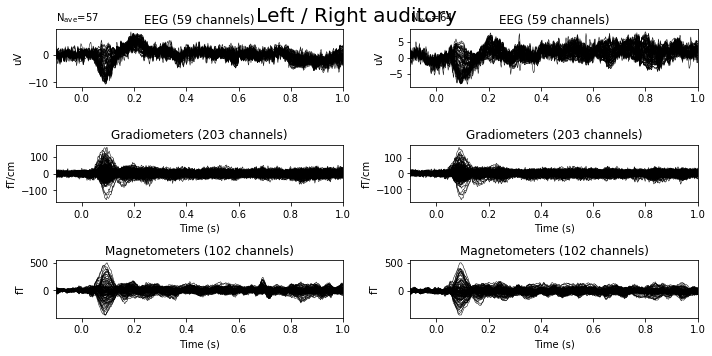

In [21]:
ev_left = epochs['Auditory/Left'].average()
ev_right = epochs['Auditory/Right'].average()

f, axs = plt.subplots(3, 2, figsize=(10, 5))
_ = f.suptitle('Left / Right auditory', fontsize=20)
_ = ev_left.plot(axes=axs[:, 0], show=False, time_unit='s')
_ = ev_right.plot(axes=axs[:, 1], show=False, time_unit='s')
plt.tight_layout()

For creating `Evoked` from other data structures see [mne.EvokedArray](https://martinos.org/mne/stable/generated/mne.EvokedArray.html#mne.EvokedArray) and [Creating MNE's data structures from scratch](https://martinos.org/mne/dev/auto_tutorials/plot_creating_data_structures.html#tut-creating-data-structures).

To export and manipulate Epochs using Pandas see
[Export epochs to pandas dataframe](https://martinos.org/mne/stable/auto_tutorials/plot_epochs_to_data_frame.html#sphx-glr-auto-tutorials-plot-epochs-to-data-frame-py),
or to work directly with metadata in MNE-Python see [Pandas querying and metadata with Epochs objects](https://martinos.org/mne/stable/auto_tutorials/plot_metadata_epochs.html#sphx-glr-auto-tutorials-plot-metadata-epochs-py).

# Visualizing epochs data

We can visualize epochs the same way as raw data

Loading data for 20 events and 662 original time points ...


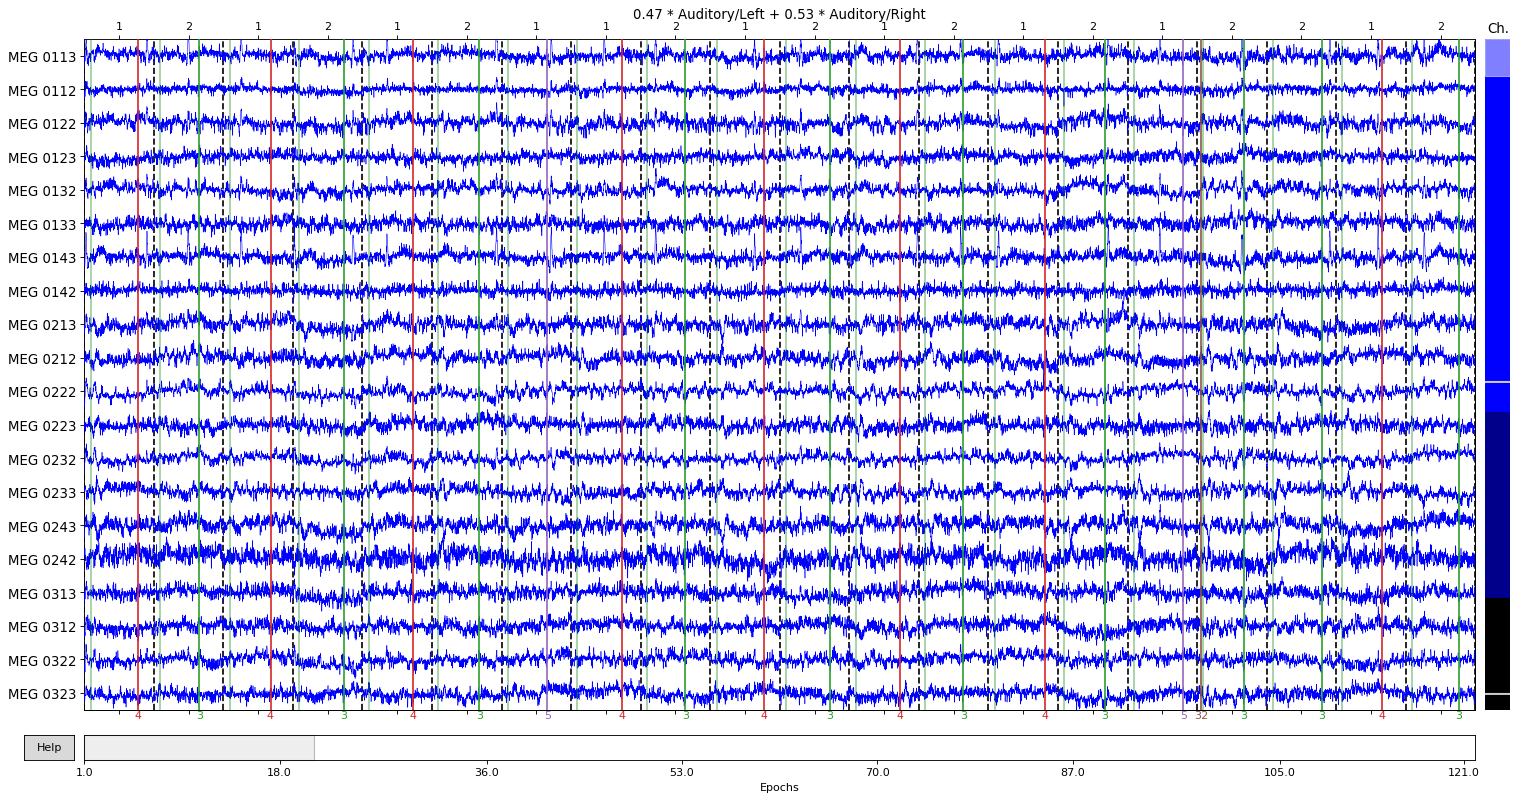

In [22]:
epochs.plot(block=True, events=events);

We can mark bad epochs interactively and scroll through the data

It's also possible to plot a single epoch as an image

Loading data for 121 events and 662 original time points ...


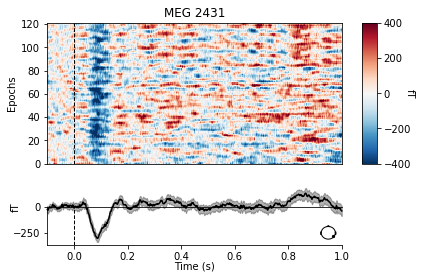

In [23]:
epochs.plot_image(278, cmap='interactive', sigma=1., vmin=-400, vmax=400);

Exercises
--------------
1) Can you find out the indices of the epochs that have been removed due to eyeblinks?

In [24]:
epochs = mne.read_epochs(epochs_fname, preload=False)
# your code here
# print(idxs)

Reading /home/mainak/Desktop/projects/github_repos/mne-python/examples/MNE-sample-data/MEG/sample/sample-epo.fif ...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
    Found the data of interest:
        t =     -99.90 ...    1000.64 ms
        0 CTF compensation matrices available
121 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
121 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 3)
3 projection items activated


2) Can you find the indices of channels corresponding to `EOG 061`?

In [25]:
# your code here
# print(epochs.info['ch_names'][picks])

3) Can you plot the EOG channel for these epochs and verify that these do indeed contain eyeblinks?

In [26]:
# your code here